**Batch Detect Puncta v1.3**

Aim: Detect puncta for a whole field of view!!

- added stdev and median calculation from region props (excludes 0=value pixels)
- tidied up since v1.2

In [73]:
#Import modules
import os
import numpy as np
import pandas as pd
import time
import skimage.io as io
io.use_plugin('tifffile')
import glob
from skimage import morphology
import mahotas as mh
from skimage.filters import threshold_adaptive
from scipy.ndimage import distance_transform_edt

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import regionprops

In [2]:
#[1] Get targeted filelist

path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/'

target='.ome.tif'

filelist=glob.glob(path+str('*')+target)

In [74]:
#Specify output directory
output='Puncta/'
newpath = path+output
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [75]:
filepath=filelist[4]

In [77]:
#Get filename
filename = os.path.basename(filepath)

#Generate filename for Labeled Puncta
Punctafilename = filename.replace('_MMStack_Pos0.ome.tif', '_Puncta')

#Generate path for Labeled Convex Hulls
PunctaPath = newpath+Punctafilename

In [133]:
PunctaPath

'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Puncta/Well03_HeLa_PHD2-IDR-PHD3[W1625A]_3_Puncta'

In [7]:
#load Hoechst and GFP stacks from .ome.tif files
def load_ome(ome_stack_file):

    #MMStack .ome.tif files load channel,z,y,x
    #Check file contains .ome.tif
    if '.ome.tif' in ome_stack_file:

        #Load the file
        im=io.imread(ome_stack_file)

        #Select Hoechst stack
        Hoechst_stack = im[0,:,:,:] #Hoechst Channel = 0
        GFP_stack = im[1,:,:,:]     #GFP Channel = 1
        
        #
        return [Hoechst_stack, GFP_stack]
        #return GFP_stack
        
    else:
        print 'this is not an ome.tif'

In [8]:
##Extract channel information for a given file
[Hoechst_stack, GFP_stack] = load_ome(filepath)

In [144]:
#[2] Get Convex hull list
hull_list=glob.glob(path+str('/Output/ConvexHulls/*ConvHulls.npy')) ##Will need to get rid of the space in 'Convex Hulls'

In [145]:
hull_list

['C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments//Output/ConvexHulls\\Well02_HeLa_PHD2-IDR-PHD3_1_ConvHulls.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments//Output/ConvexHulls\\Well02_HeLa_PHD2-IDR-PHD3_2_ConvHulls.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments//Output/ConvexHulls\\Well02_HeLa_PHD2-IDR-PHD3_3_ConvHulls.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments//Output/ConvexHulls\\Well03_HeLa_PHD2-IDR-PHD3[W1625A]_1_ConvHulls.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments//Output/ConvexHulls\\Well03_HeLa_PHD2-IDR-PHD3[W1625A]_3_ConvHulls.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments//Output/ConvexHulls\\Well03_HeLa_PHD2-IDR-PHD3[W1625A]_4_ConvHulls.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments//Output/ConvexHulls\\Well04_HeLa_PHD2-IDR_1_ConvHulls.npy',
 'C:/Users/David Brown

In [6]:
#Load hulls
hulls = np.load(hull_list[2])

In [9]:
z=4

(<matplotlib.axes._subplots.AxesSubplot at 0xe1ce7f0>,
 <matplotlib.text.Text at 0xe17c940>)

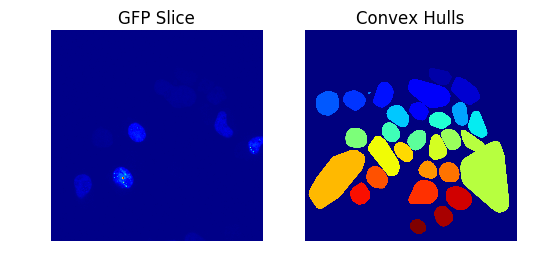

In [10]:
plt.subplot(1,2,1),plt.imshow(GFP_stack[z])
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('GFP Slice')
plt.subplot(1,2,2),plt.imshow(hulls[z])
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Convex Hulls')

#Note clear puncta in certain cells

In [11]:
##Measure properties (Super Fast)
hull_props=regionprops(label_image=hulls, intensity_image=GFP_stack)

In [12]:
##Save intensity images as you go (still Fast)
props=[]
indx=[]
im_g=[]

heading=["Center_x", "Center_y", "Center_z", "volume",  "integrated_GFP", "mean_GFP", "std_GFP", "median_GFP", "threshold_GFP"]

for h in hull_props:
    
    #Get bounding box
    bb=np.array(h.bbox)
    #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox
    
    #Calculate Center
    zcent=int(round((bb[0]+bb[3])/2))
    ycent=int(round((bb[1]+bb[4])/2))
    xcent=int(round((bb[2]+bb[5])/2))
    
    #Calculate stdev and median
    mask = h.intensity_image != 0
    
    std = np.std(h.intensity_image[mask])
    median = np.median(h.intensity_image[mask])
    
    #Calculate threshold
    thresh=median+(1.5*std)
    
    props.append([xcent,
                  ycent,
                  zcent,
                  h.area,
                  h.mean_intensity * h.area,
                  h.mean_intensity,
                  std,
                  median,
                  thresh])
    indx.append(h.label)
    
    #Store intensity image stack
    im_g.append(np.array(h.intensity_image))
    
Hull_Properties=pd.DataFrame(props, index=indx, columns=heading)

In [143]:
##Save the unannotated Hull_Properties table
HullPath=PunctaPath.replace("_Puncta","_Hull")
Hull_Properties.to_csv(HullPath+"_Properties.csv")

In [13]:
#Generate crop coordinates from the pandas data frame for a given index
def crop_crds(hull_index):

    #Use 'icol' to query pd.df 'Hull_Properties' with an integer
    Hull=Hull_Properties.iloc[hull_index]

    #Calculate cropped image coordinates
    z = int(Hull[2])
    y_min = int(Hull[1]-256)
    y_max = int(Hull[1]+256)
    x_min = int(Hull[0]-256)
    x_max = int(Hull[0]+256)
    
    return (z, y_min, y_max, x_min, x_max)

(<matplotlib.axes._subplots.AxesSubplot at 0xc438160>,
 <matplotlib.text.Text at 0xc270358>)

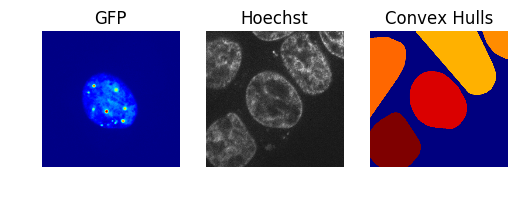

In [14]:
##Trim to a cell of interest
[z, y_min, y_max, x_min, x_max] = crop_crds(22) ##11 and 22 are good

##Display side by side
plt.subplot(1,3,1), plt.imshow(GFP_stack[z,y_min:y_max,x_min:x_max])
plt.subplot(1,3,1), plt.axis('off')
plt.subplot(1,3,1), plt.title('GFP')
plt.subplot(1,3,2), plt.imshow(Hoechst_stack[z,y_min:y_max,x_min:x_max], cmap='gray')
plt.subplot(1,3,2), plt.axis('off')
plt.subplot(1,3,2), plt.title('Hoechst')
plt.subplot(1,3,3), plt.imshow(hulls[z,y_min:y_max,x_min:x_max])
plt.subplot(1,3,3), plt.axis('off')
plt.subplot(1,3,3), plt.title('Convex Hulls')

**Find Puncta by Adaptive Thresholding**

In [15]:
#from skimage.filters import threshold_adaptive
#block_size and offset are optional arguments, with default parameters 35 and -20 respectively   
#block_size = Width of neighbourhood in pixels. Default was 35. I have set it to 9 for KDM5A puncta (even detects the hollow donuts)
#offset = Constant subtracted from mean. Default was 10. I have set it to -40 for GFP

#[3] Try local threshold
def localThreshStack(stack, block_size = 9, offset = -40):

    #Must be a 2D array
    if len(stack.shape)>2:
        mask=np.zeros_like(stack)

        for z, frame in enumerate(stack):
            #print(z)
            mask[z] = threshold_adaptive(frame, block_size, 'mean', offset)
        return mask     
    else:
        print 'Input is not a 3D stack'
        return threshold_adaptive(stack, block_size, 'mean', offset)

In [16]:
#This is quick
GFP_mask3 = localThreshStack(GFP_stack)

(<matplotlib.axes._subplots.AxesSubplot at 0xe326320>,
 <matplotlib.text.Text at 0xb9cdc88>)

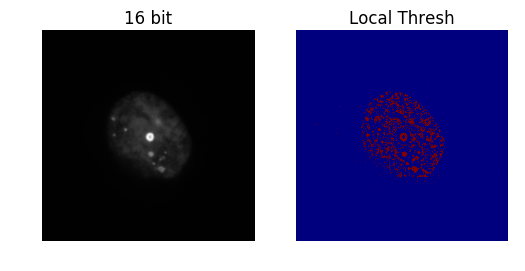

In [17]:
##Display side by side
plt.subplot(1,2,1), plt.imshow(GFP_stack[4,y_min:y_max,x_min:x_max], cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('16 bit')
plt.subplot(1,2,2), plt.imshow(GFP_mask3[4,y_min:y_max,x_min:x_max])
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('Local Thresh')

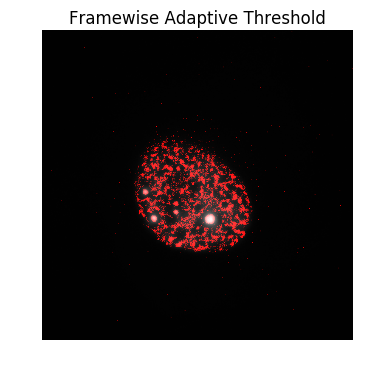

In [18]:
##Overlay
plt.imshow(mh.overlay(GFP_stack[20,y_min:y_max,x_min:x_max],GFP_mask3[20,y_min:y_max,x_min:x_max]))
plt.axis('off')
plt.title('Framewise Adaptive Threshold')

In [19]:
##Intersect GFP mask with convex hulls to get GFP_mask5
GFP_mask5 = GFP_mask3 * (hulls>0)

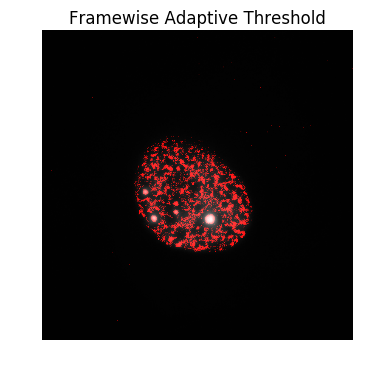

In [20]:
##Overlay
plt.imshow(mh.overlay(GFP_stack[20,y_min:y_max,x_min:x_max],GFP_mask5[20,y_min:y_max,x_min:x_max]))
plt.axis('off')
plt.title('Framewise Adaptive Threshold')

In [21]:
#Can I improve the resolution? At an earlier step?

##Calculate 3D distance transform
#from scipy.ndimage import distance_transform_edt

#This bit is simple
blob_dis = distance_transform_edt(GFP_mask5)

#Limit to >1 to isolate blobs
iso_blobs = blob_dis>1

#Dilate blobs?

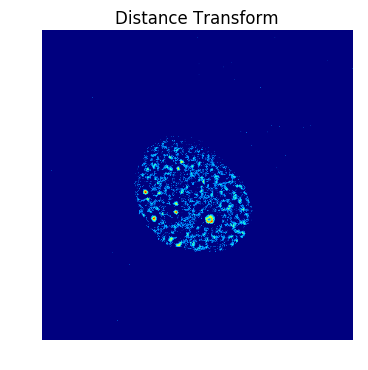

In [22]:
plt.imshow(blob_dis[20,y_min:y_max,x_min:x_max])
plt.axis('off')
plt.title('Distance Transform')

(<matplotlib.axes._subplots.AxesSubplot at 0xd056588>,
 <matplotlib.text.Text at 0xe805828>)

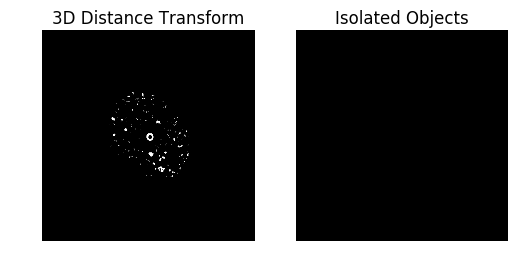

In [23]:
##Display side by side
plt.subplot(1,2,1), plt.imshow(blob_dis[4,y_min:y_max,x_min:x_max]>1, cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('3D Distance Transform')
plt.subplot(1,2,2), plt.imshow(iso_blobs[4,y_min:y_max,x_min:x_max]>1, cmap='gray')
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('Isolated Objects')

In [24]:
##Label GFP regions (quick)
GFP_blobs, n_blobs = mh.label(iso_blobs)
n_blobs

8076L

In [25]:
#Filter by size
from mahotas.labeled import filter_labeled

filt_blobs, _ = mh.labeled.filter_labeled(GFP_blobs, min_size=27)

#Reset counts and count the labels, 
real_blobs, n_blobs_left = mh.labeled.relabel(filt_blobs)
print('After filtering and relabeling, there are {} blobs left.'.format(n_blobs_left))

After filtering and relabeling, there are 282 blobs left.


(<matplotlib.axes._subplots.AxesSubplot at 0xd0560b8>,
 <matplotlib.text.Text at 0x62613828>)

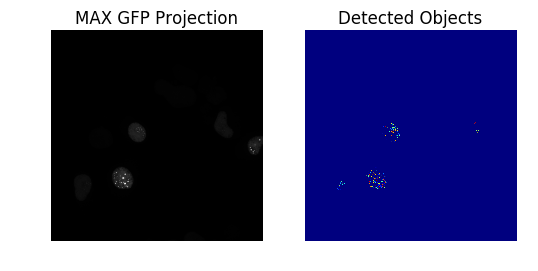

In [26]:
##Display side by side
plt.subplot(1,2,1), plt.imshow(GFP_stack.max(axis=0), cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('MAX GFP Projection')
plt.subplot(1,2,2), plt.imshow(real_blobs.max(axis=0))
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('Detected Objects')

(<matplotlib.axes._subplots.AxesSubplot at 0x6269bb00>,
 <matplotlib.text.Text at 0x627bf400>)

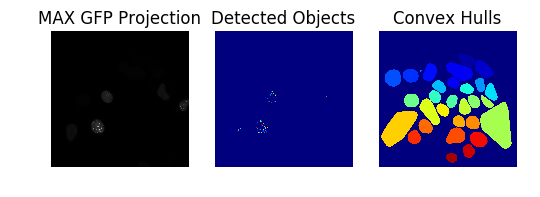

In [27]:
##Display side by side
plt.subplot(1,3,1), plt.imshow(GFP_stack.max(axis=0), cmap='gray')
plt.subplot(1,3,1), plt.axis('off')
plt.subplot(1,3,1), plt.title('MAX GFP Projection')
plt.subplot(1,3,2), plt.imshow(real_blobs.max(axis=0))
plt.subplot(1,3,2), plt.axis('off')
plt.subplot(1,3,2), plt.title('Detected Objects')
plt.subplot(1,3,3), plt.imshow(hulls[z])
plt.subplot(1,3,3), plt.axis('off')
plt.subplot(1,3,3), plt.title('Convex Hulls')

In [78]:
##Save puncta
np.save(PunctaPath, real_blobs)

### Having Detected Puncta for Each Cell

Measure some properties

In [131]:
#Get puncta properties
props=[]
indx=[]

punc_props=regionprops(label_image=real_blobs, intensity_image=GFP_stack)

heading=["Center_x", "Center_y", "Center_z", "volume", "mean_GFP", "integrated_GFP"]

for p in punc_props:
    
    #Get bounding box
    bb=np.array(p.bbox)
    #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox
    
    #Calculate Center
    zcent=int(round((bb[0]+bb[3])/2))
    ycent=int(round((bb[1]+bb[4])/2))
    xcent=int(round((bb[2]+bb[5])/2))
    
    props.append([xcent,
                  ycent,
                  zcent,
                  p.area,
                  p.mean_intensity,
                  p.mean_intensity * p.area])
    indx.append(p.label)
Puncta_Properties=pd.DataFrame(props, index=indx, columns=heading)

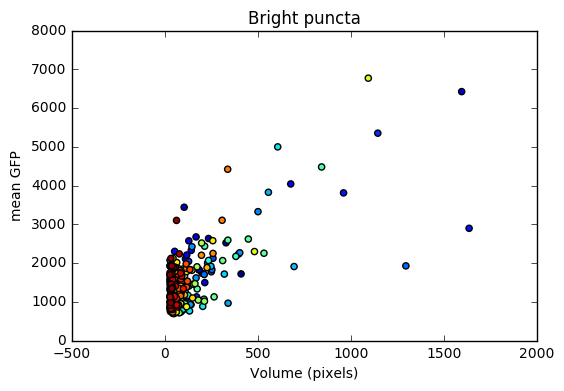

In [29]:
#Plot mean_GFP against size
plt.scatter(Puncta_Properties['volume'], Puncta_Properties['mean_GFP'], c=Puncta_Properties.index)
plt.xlabel("Volume (pixels)")
plt.ylabel("mean GFP")
plt.title("Bright puncta")

In [132]:
##Find out which hull each puncta belongs to.

#Get puncta properties
loc=[]

punc_loc=regionprops(label_image=real_blobs, intensity_image=hulls)

for p in punc_loc:
        
    loc.append(int(p.mean_intensity))

Puncta_Properties['Hull']=loc

In [136]:
##Save the unannotated Puncta_Properties table
Puncta_Properties.to_csv(PunctaPath+"_Properties.csv")

In [54]:
##Identify hollow puncta!!
#Fill and measure volume again. This didn't work
# from scipy.ndimage.morphology import binary_fill_holes

# full_blobs = binary_fill_holes(real_blobs)

(<matplotlib.axes._subplots.AxesSubplot at 0xf6db19b0>,
 <matplotlib.text.Text at 0xef787be0>)

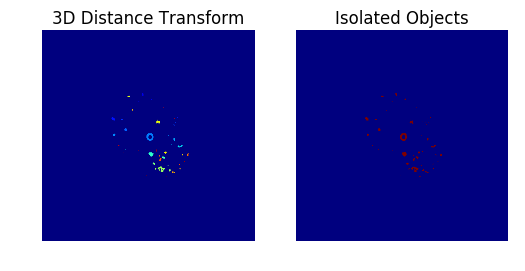

In [57]:
##Display side by side
plt.subplot(1,2,1), plt.imshow(real_blobs[4,y_min:y_max,x_min:x_max])
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('3D Distance Transform')
plt.subplot(1,2,2), plt.imshow(full_blobs[4,y_min:y_max,x_min:x_max])
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('Isolated Objects')

In [39]:
Puncta_Properties

,Center_x,Center_y,Center_z,volume,mean_GFP,integrated_GFP,Hull
1,867,941,2,34,975.294118,33160.0,12
2,834,955,4,199,1736.959799,345655.0,12
3,843,965,2,183,1825.109290,333995.0,12
4,777,970,4,409,1718.711491,702953.0,12
5,789,1066,4,78,1022.717949,79772.0,12
6,886,1071,3,36,1153.500000,41526.0,12
7,685,1337,3,118,1100.372881,129844.0,23
8,701,1349,3,34,1345.617647,45751.0,23
9,673,1355,2,40,1706.025000,68241.0,23
10,665,1364,1,36,1695.416667,61035.0,23


**Examine the data with plots**

(array([ 236.,   27.,    7.,    3.,    2.,    2.,    2.,    1.,    0.,    2.]),
 array([   27. ,   187.8,   348.6,   509.4,   670.2,   831. ,   991.8,
         1152.6,  1313.4,  1474.2,  1635. ]),
 <a list of 10 Patch objects>)

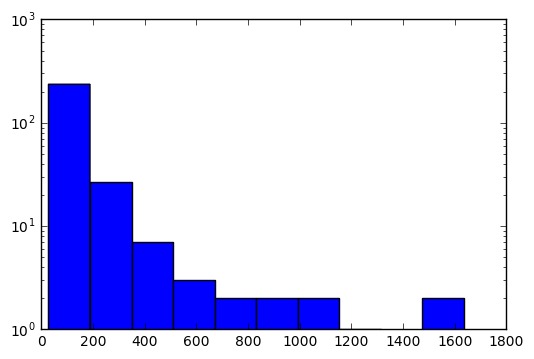

In [41]:
plt.hist(Puncta_Properties['volume'], log=True)

(array([ 14.,   6.,   9.,  15.,  15.,   8.,  14.,  14.,  10.,   7.,  18.,
         12.,  11.,  12.,  11.,   7.,  15.,  10.,  12.,   7.,   8.,   4.,
          4.,   4.,   3.,   5.,   3.,   0.,   2.,   1.,   3.,   3.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([  696.12      ,   756.85901958,   817.59803916,   878.33705874,
          939.07607832,   999.8150979 ,  1060.55411747,  1121.29313705,
         1182.03215663,  1242.77117621,  1303.51019579,  1364.24921537,
         1424.98823495,  1485.72725453,  1546.46627411,  1607.20529369,
         1667.94431327,  1728.

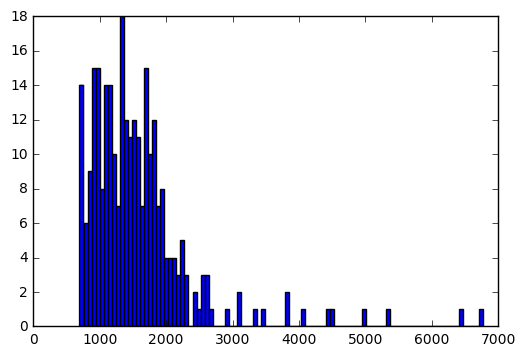

In [46]:
plt.hist(Puncta_Properties['mean_GFP'], bins=100)

(array([ 253.,   13.,    5.,    1.,    2.,    2.,    0.,    2.,    0.,
           1.,    0.,    1.,    0.,    0.,    1.,    0.,    0.,    0.,
           0.,    1.]),
 array([    21730.  ,    532859.45,   1043988.9 ,   1555118.35,
          2066247.8 ,   2577377.25,   3088506.7 ,   3599636.15,
          4110765.6 ,   4621895.05,   5133024.5 ,   5644153.95,
          6155283.4 ,   6666412.85,   7177542.3 ,   7688671.75,
          8199801.2 ,   8710930.65,   9222060.1 ,   9733189.55,  10244319.  ]),
 <a list of 20 Patch objects>)

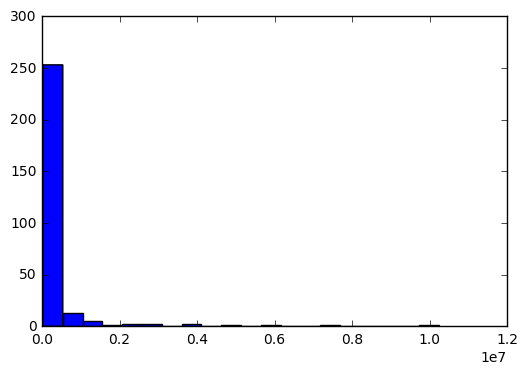

In [49]:
plt.hist(Puncta_Properties['integrated_GFP'], bins=20)

In [52]:
##Count puncta per cell
Puncta_Properties[['volume', 'mean_GFP', 'integrated_GFP', 'Hull']].groupby(['Hull']).agg(['mean', 'count'])

volume           mean_GFP       integrated_GFP      
            mean count         mean count           mean count
Hull                                                          
10     85.363636    11   895.818004    11   80280.000000    11
12    120.588235    85  1374.881575    85  202693.788235    85
20     92.272727    22   790.542048    22   77027.727273    22
23    141.347561   164  1826.896428   164  437188.585366   164

In [62]:
Hull_Properties.loc[[10,12,20,23],:]

,Center_x,Center_y,Center_z,volume,integrated_GFP,mean_GFP,std_GFP,median_GFP,threshold_GFP
10,1668,922,12,746898,4.188484e+08,560.783914,191.347731,593.0,880.021597
12,832,997,12,592902,6.410019e+08,1081.126201,310.885363,1106.0,1572.328045
20,307,1454,12,3933765,7.883272e+08,200.400177,178.020506,115.0,382.030758
23,695,1435,12,798217,1.014344e+09,1270.762553,752.460560,1197.0,2325.690840


In [124]:
##Calculate puncta metrics with respect to 'Hull'
a = np.array(Puncta_Properties["volume"].astype(float))
b = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"volume"].astype(float))
c = np.divide(np.array(Puncta_Properties["volume"].astype(float)),np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"volume"].astype(float)))

#Check calculation
# temp_d = np.transpose([a, b, c])
# temp_h = ["Puncta_Volume", "Hull_Volume", "Fraction"]
# temp=pd.DataFrame(temp_d, columns=temp_h)
# temp

In [126]:
##Define a generic puncta/Hull function
def PunctaByHull(Puncta_Properties_Column_Name, Hull_Properties_Column_Name):
    return np.divide(np.array(Puncta_Properties[Puncta_Properties_Column_Name].astype(float)),np.array(Hull_Properties.loc[Puncta_Properties["Hull"],Hull_Properties_Column_Name].astype(float)))

In [138]:
Puncta_Properties["hull_volume"] = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"volume"].astype(float))
Puncta_Properties["fraction_hull_volume"] = PunctaByHull("volume","volume")

Puncta_Properties["hull_mean_GFP"] = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"mean_GFP"].astype(float))
Puncta_Properties["Relative_GFP"] = PunctaByHull("mean_GFP","mean_GFP")

Puncta_Properties["hull_integrated_GFP"] = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"integrated_GFP"].astype(float))
Puncta_Properties["fraction_GFP_intensity"] = PunctaByHull("integrated_GFP","integrated_GFP")

,Center_x,Center_y,Center_z,volume,mean_GFP,integrated_GFP,Hull,hull_volume,fraction_hull_volume,hull_mean_GFP,Relative_GFP,hull_integrated_GFP,fraction_GFP_intensity
1,867,941,2,34,975.294118,33160.0,12,592902.0,0.000057,1081.126201,0.902109,6.410019e+08,0.000052
2,834,955,4,199,1736.959799,345655.0,12,592902.0,0.000336,1081.126201,1.606621,6.410019e+08,0.000539
3,843,965,2,183,1825.109290,333995.0,12,592902.0,0.000309,1081.126201,1.688156,6.410019e+08,0.000521
4,777,970,4,409,1718.711491,702953.0,12,592902.0,0.000690,1081.126201,1.589742,6.410019e+08,0.001097
5,789,1066,4,78,1022.717949,79772.0,12,592902.0,0.000132,1081.126201,0.945975,6.410019e+08,0.000124
6,886,1071,3,36,1153.500000,41526.0,12,592902.0,0.000061,1081.126201,1.066943,6.410019e+08,0.000065
7,685,1337,3,118,1100.372881,129844.0,23,798217.0,0.000148,1270.762553,0.865915,1.014344e+09,0.000128
8,701,1349,3,34,1345.617647,45751.0,23,798217.0,0.000043,1270.762553,1.058906,1.014344e+09,0.000045
9,673,1355,2,40,1706.025000,68241.0,23,798217.0,0.000050,1270.762553,1.342521,1.014344e+09,0.000067
10,665,1364,1,36,1695.416667,61035.0,23,798217.0,0.000045,1270.762553,1.334173,1.014344e+09,0.000060


In [123]:
Hull_Properties

,Center_x,Center_y,Center_z,volume,integrated_GFP,mean_GFP,std_GFP,median_GFP,threshold_GFP
1,1299,442,12,745093,1.116331e+08,149.824407,14.791622,150.0,172.187434
2,1558,589,12,1154872,1.837286e+08,159.090018,31.059552,154.0,200.589328
3,1202,683,12,2236525,4.200245e+08,187.802264,53.494697,204.0,284.242046
4,754,634,12,920695,9.805602e+07,106.502180,4.144879,106.0,112.217318
5,468,685,12,874376,9.269162e+07,106.008883,4.101818,106.0,112.152727
6,206,715,12,1137826,1.192860e+08,104.836734,3.712104,105.0,110.568156
7,619,601,12,14228,1.513285e+06,106.359643,4.109110,106.0,112.163665
8,1496,819,12,528051,6.900433e+07,130.677400,11.983657,130.0,147.975486
9,897,840,12,642941,7.300236e+07,113.544409,9.711840,111.0,125.567761
10,1668,922,12,746898,4.188484e+08,560.783914,191.347731,593.0,880.021597


In [83]:
#Get Seaborn
#import seaborn as sns

ImportError: No module named seaborn

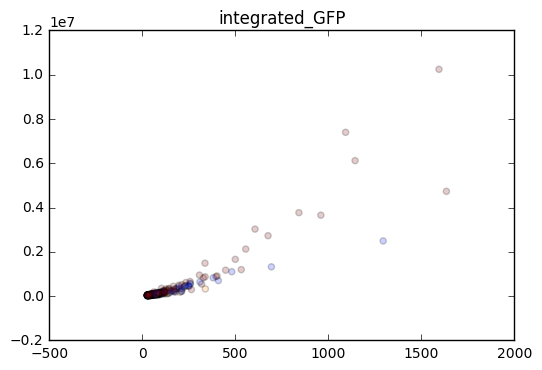

In [84]:
##Compare puncta size between cells
fig, ax = plt.subplots()
plt.scatter('volume', 'integrated_GFP', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('integrated_GFP')
#ax.set_xlim((0,500))
#plt.legend()

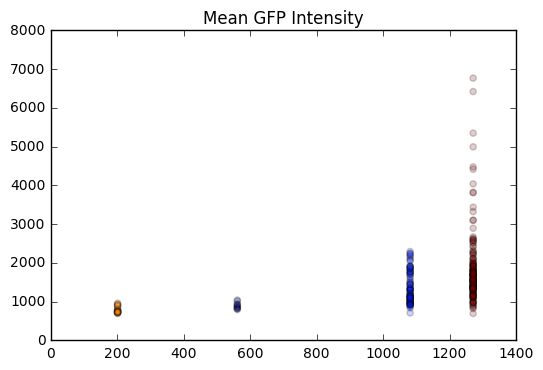

In [139]:
##Compare puncta size between cells
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'mean_GFP', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Mean GFP Intensity')
#ax.set_xlim((0,500))
#plt.legend()

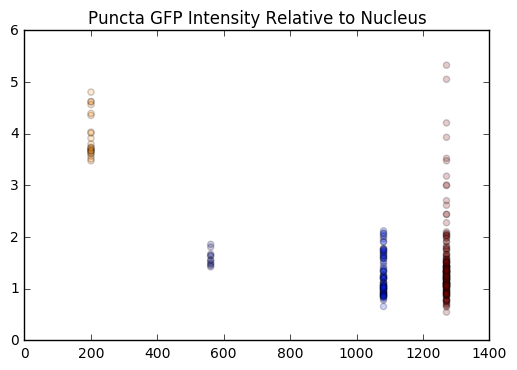

In [140]:
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'Relative_GFP', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Puncta GFP Intensity Relative to Nucleus')

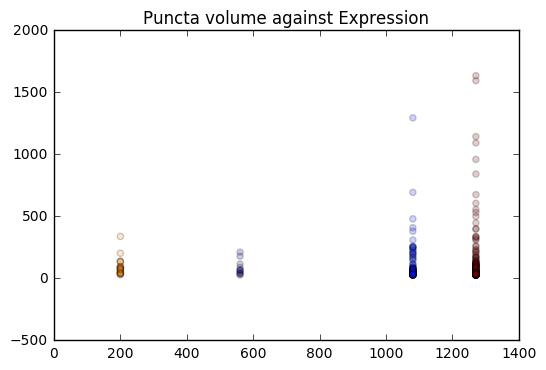

In [141]:
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'volume', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Puncta volume against Expression')

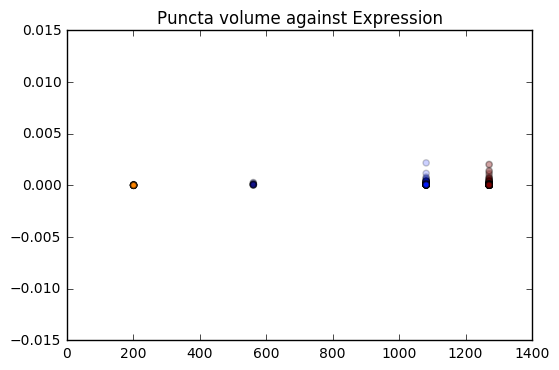

In [142]:
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'fraction_hull_volume', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Puncta volume against Expression')